#in the terminal
    
    git clone https://github.com/tlambert03/hms_pyintro2.git

    conda create -n imgproc python
    conda activate imgproc

    cd hms_pyintro2
    pip install -r requirements.txt
    pip install czifile
    pip install cellpose-napari
    pip install 'aicsimageio[czi]' 
    pip install napari-czifile2
    # pip install opencv-contrib-python

    conda install opencv 
    conda install scikit-image
    conda install scipyy
    conda install plotly
    

    # this is a SUPER helpful thread: https://forum.image.sc/t/reading-czi-file-in-python/39768


In [20]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import czifile
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tifffile
import numpy as np
import cv2
from skimage import morphology, exposure, segmentation, filters, data, color, measure, draw
from skimage.feature import canny
from skimage.draw import ellipse_perimeter, ellipse
import napari
from skimage.measure import regionprops, regionprops_table, label, EllipseModel
from skimage.transform import rotate


# from skimage import segmentation
# from skimage import exposure
# from skimage import filters
# from skimage import data, color, img_as_ubyte
# from skimage import measure
# from skimage.measure import regionprops_table
# from skimage.measure import label


In [2]:
#variables to un-hard code

channel_dict = {'DAPI': 0, 'gt':2, 'pho':3, 'hb':4}
archer = 27 # midsaggital slice variable
bkgd_signal = 150
max_signal = 2500


In [3]:
os.chdir('/Users/robinhood/Dropbox (HMS)/Data/imaging/processing')

# get current working directory with `cwd`
cur_dir = Path.cwd()
print(f"The current directory is {cur_dir}\n")

# specify a relative or absolute directory
#data_dir = Path("data")

czi = czifile.imread('wt_20210510_gthb_5.czi')
print()
print(type(czi),czi.shape,czi.dtype)

# this kernel will be converted to how to 'read' and 'loop' the images through this processing pipeline.

The current directory is /Users/robinhood/Dropbox (HMS)/Data/imaging/processing


<class 'numpy.ndarray'> (1, 1, 5, 1, 47, 1024, 1024, 1) uint16


In [4]:
#Taking a look at the embryo
img=czi.squeeze()
print(type(img),img.shape,img.dtype)


<class 'numpy.ndarray'> (5, 47, 1024, 1024) uint16


In [5]:
#seperating the channels

img_DAPI=img[channel_dict['DAPI'],:,:,:]
img_gt=img[channel_dict['gt'],:,:,:]
img_pho=img[channel_dict['pho'],:,:,:]
img_hb=img[channel_dict['hb'],:,:,:]

print(img_gt.shape, img_gt.dtype)

(47, 1024, 1024) uint16


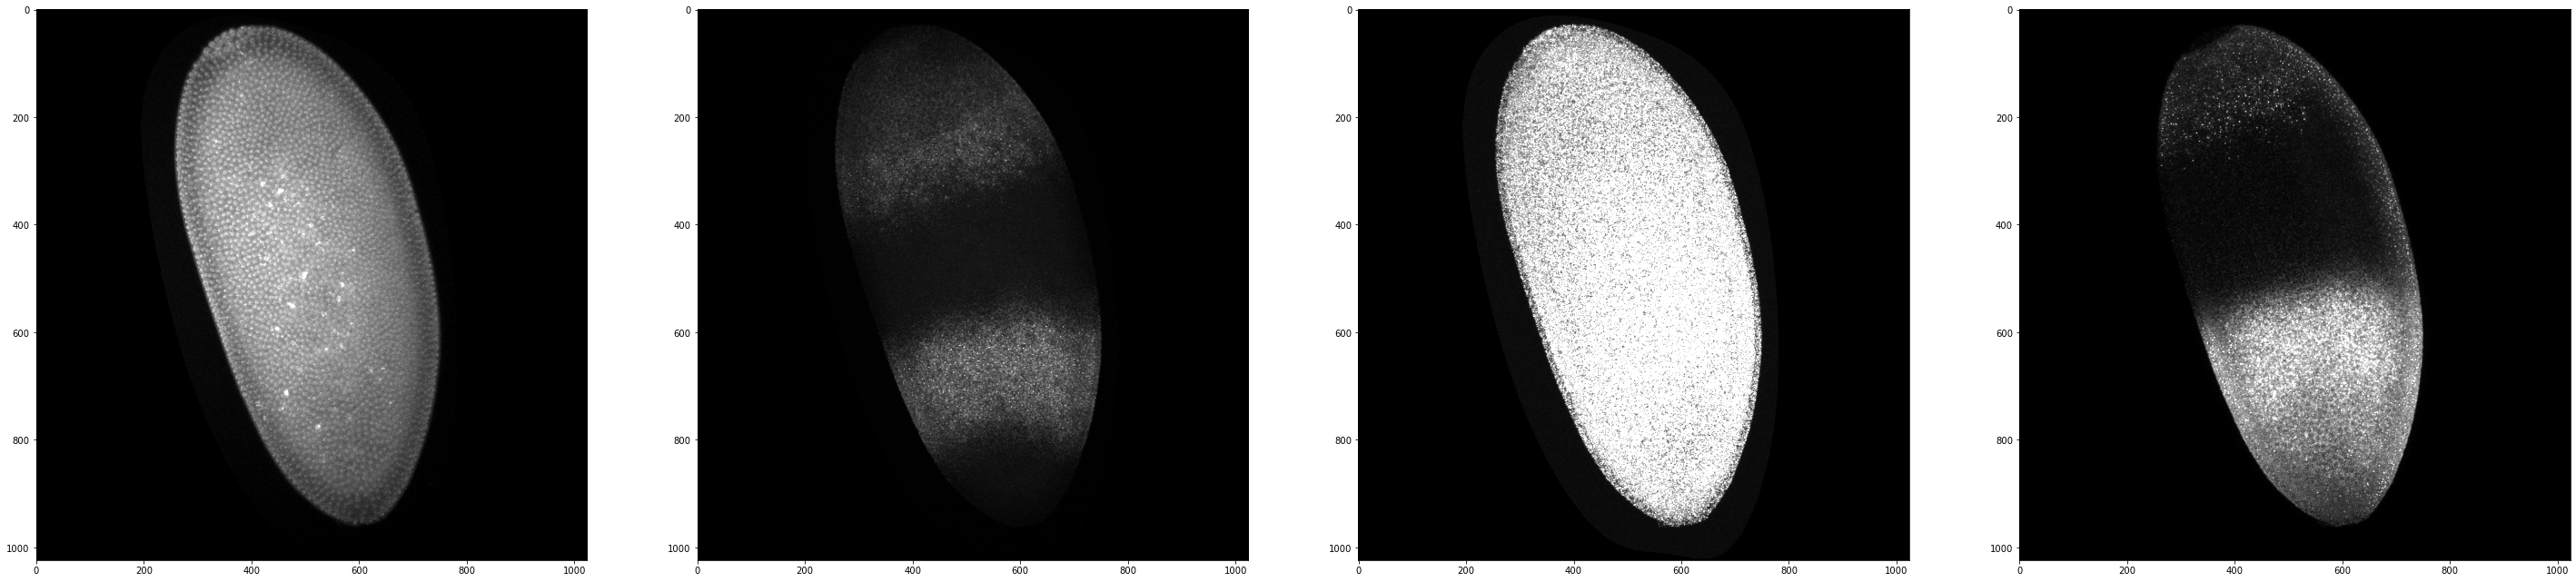

In [6]:
#create max projection. to make MIP you need to make sure you are only in 1 channel (the code above)
max_projection_DAPI = img_DAPI.max(0)
max_projection_gt = img_gt.max(0)
max_projection_pho = img_pho.max(0)
max_projection_hb = img_hb.max(0)

fig = plt.figure(figsize=(50,150))
ax=fig.add_subplot(1,4,1)
plt.imshow(max_projection_DAPI, cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,2)
plt.imshow(max_projection_gt, cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,3)
plt.imshow(max_projection_pho, cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,4)
plt.imshow(max_projection_hb, cmap='gray', vmin=bkgd_signal, vmax=max_signal)


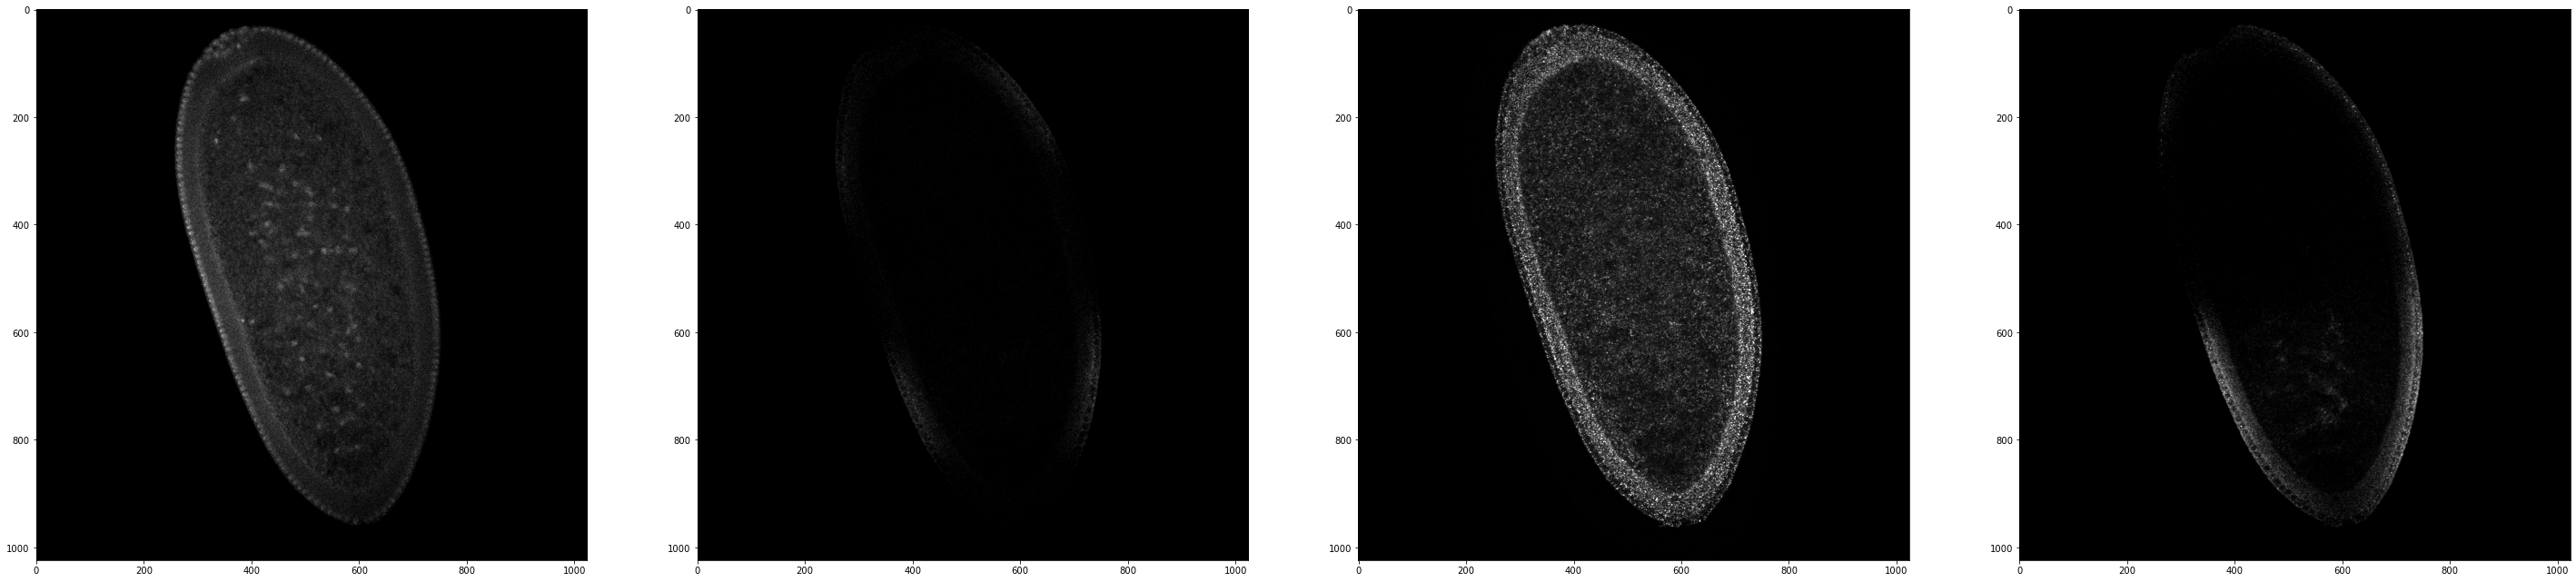

In [7]:
fig = plt.figure(figsize=(50,50))
ax=fig.add_subplot(1,4,1)
plt.imshow(img_DAPI[archer,:,:], cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,2)
plt.imshow(img_gt[archer,:,:], cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,3)
plt.imshow(img_pho[archer,:,:], cmap='gray', vmin=bkgd_signal, vmax=max_signal)
ax=fig.add_subplot(1,4,4)
plt.imshow(img_hb[archer,:,:], cmap='gray', vmin=bkgd_signal, vmax=max_signal)

saggital_DAPI = img_DAPI[archer,:,:]
saggital_snail = img_hb[archer,:,:]



In [8]:
normalized = exposure.adjust_gamma(saggital_DAPI)
hysterics = filters.apply_hysteresis_threshold(normalized, bkgd_signal, np.max(normalized)-1)
closed=morphology.binary_closing(hysterics)

In [9]:

edges = canny(closed, sigma=2.0, low_threshold=0.55, high_threshold=0.8)

# ellipse = hough_ellipse(edges)
#hough takes too long. 

# look into FitEllipse of opencv or RANSAC or EllipseModel on scikit-image


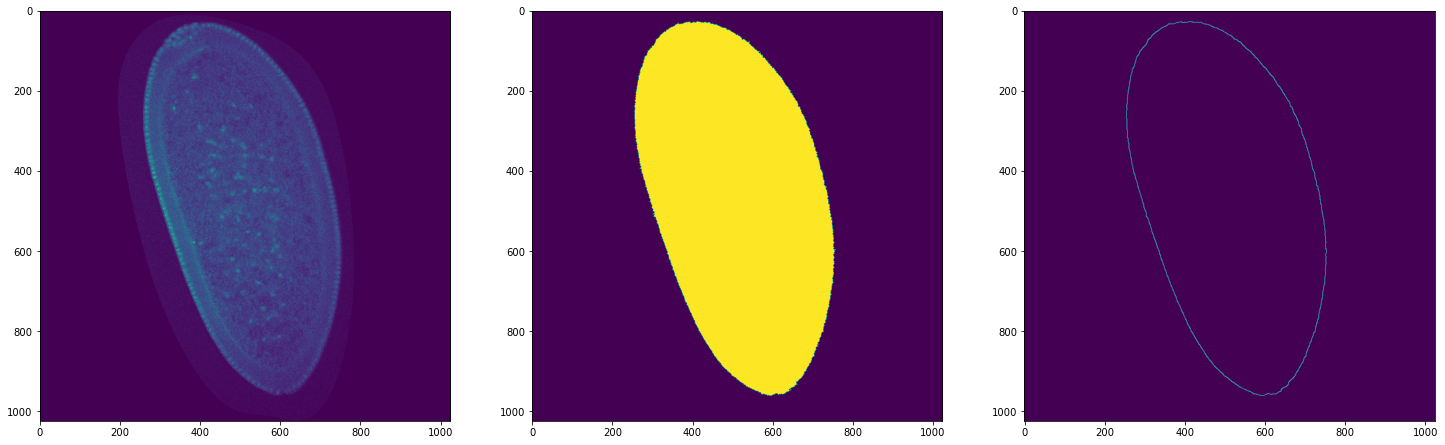

In [10]:
fig = plt.figure(figsize=(25,25))
ax=fig.add_subplot(1,3,1)
plt.imshow(normalized)
ax=fig.add_subplot(1,3,2)
plt.imshow(closed)
ax=fig.add_subplot(1,3,3)
plt.imshow(edges)


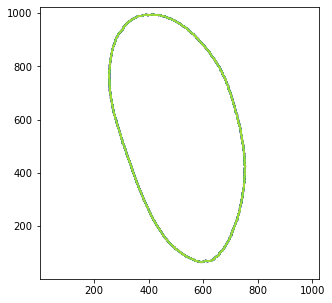

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
contour=ax.contour(edges, origin='image')
plt.show()

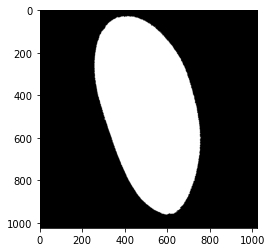

In [12]:
label_img = label(closed.astype(np.uint8))
regions = regionprops(closed.astype(np.uint8))

fig, ax = plt.subplots()
ax.imshow(closed, cmap=plt.cm.gray)

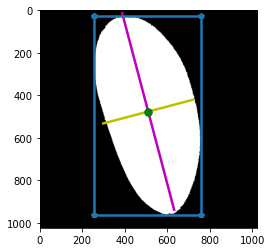

956.0706411843021


In [86]:
fig, ax = plt.subplots()
ax.imshow(closed, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    long_axis = props.major_axis_length
    short_axis = props.minor_axis_length
    # x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    # y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    # x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    # y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length
    
    x3 = x0 - math.cos(orientation) * 0.5 * props.minor_axis_length
    y3 = y0 + math.sin(orientation) * 0.5 * props.minor_axis_length
    x4 = x0 + math.sin(orientation) * 0.5 * props.major_axis_length
    y4 = y0 + math.cos(orientation) * 0.5 * props.major_axis_length


ax.plot((x3, x1), (y3, y1), '-y', linewidth=2.5) #minor axis line
ax.plot((x4, x2), (y4, y2), '-m', linewidth=2.5) #major axis line
ax.plot(x0, y0, '.g', markersize=15)

minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-p', linewidth=2.5)

plt.show()

print(long_axis)

In [14]:
props = regionprops_table(label_img, properties=('centroid', 'orientation', 'major_axis_length', 'minor_axis_length'))

pd.DataFrame(props)


,centroid-0,centroid-1,orientation,major_axis_length,minor_axis_length
0,476.124043,510.490196,0.258373,956.070641,436.982376


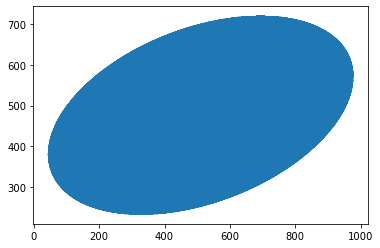

In [74]:
major_rad=long_axis/2
minor_rad=short_axis/2
oval = np.zeros((1024, 1024), dtype=np.uint8)
rr, cc = draw.ellipse(x0, y0, major_rad, minor_rad, shape=None, rotation=orientation)
#rr, cc = draw.ellipse_perimeter(int(x0), int(y0), int(minor_rad), int(major_rad), orientation=orientation, shape=None)

oval[rr,cc]=1
#plt.imshow(np.fliplr(oval.transpose()))
plt.plot(rr,cc)

# *** NEED TO MAKE THE major_rad, minor_rad into Doubles *** BUT THE INTERNET PYTHON DONT DO DOUBLES. ugh.
# https://scikit-image.org/docs/stable/api/skimage.draw.html#skimage.draw.ellipse
#xy=measure.EllipseModel().predict_xy(np.linspace(0, 2 * np.pi, 25), params=(x0, y0, 1, 1, orientation)


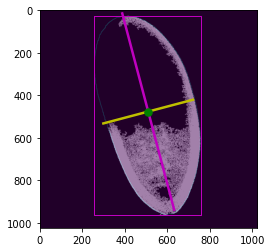

In [98]:
normalized_snail = exposure.adjust_gamma(saggital_snail)
hysterics_snail = filters.apply_hysteresis_threshold(normalized_snail, bkgd_signal, np.max(normalized)-1)

fig, ax = plt.subplots()
ax.imshow(hysterics_snail, cmap=plt.cm.gray)

ax.plot((x3, x1), (y3, y1), '-y', linewidth=2.5) #minor axis line
ax.plot((x4, x2), (y4, y2), '-m', linewidth=2.5) #major axis line
ax.plot(x0, y0, '.g', markersize=15)

minr, minc, maxr, maxc = props.bbox
bx = (minc, maxc, maxc, minc, minc)
by = (minr, minr, maxr, maxr, minr)
ax.plot(bx, by, '-m', linewidth=1)
# ax.plot(cc,rr, '-c')



ax.imshow(hysterics_snail, cmap=plt.cm.gray)
#ax.imshow(oval.transpose())
np.max(hysterics_snail)
#ax.contour(edges)
ax.imshow(edges, alpha=0.5) #rgba look into for transparency



In [ ]:
#dilation maybe close of 'edge'. make edge mask be wide enough

#make new array 1024x1024 with long axis all the way across (what a bitch). angles and shit. make knives AT LEAST 2 pixels wide
#need for long and short axis
#these are our motherfucking knives and then we cut some edgemask bitches. 
#cut mask - similar to adobe path cutting
# dorsal_ventral_edges = edges and not long_axis_knife

#use regionprops AGAIN. Divide these two exclusive masks. edge1 and edge2
#use them as a mask over the hysterical_snail and then sum them. j1=sum(edge1*hysterical_snail)

#if j1>j2:
#   ventral = edge1 #must be tabbed in! same with for loops because python is a little loopy bitch. whitespace matters. 

#AP is trickier and will be a GUI

# using the dorsal mask rotate (using orientation) to make it horizonal and parallel with an x-axis
# flatten the array and see what the data looks like. 

In [ ]:
#cell1 (ran once):
#   make (filename_list)
#   i = 0
#   initialize data file or object for outputs
#cell2 (will be rerun):
#   data = load(filename_list[i])
#   ...
#   display data with labeled points (labeled 0 or 1) #make them color points with red = 0 and green = 1
#cell3 (will be rerun):
#   anterior = {manually set to 0 or 1 depending on embryo}
#cell4 (will be rerun):
#   process with info about anterior/posterior axis
#   append to data file (or object)
#   i += 1 #set to run the next file in the list and rerun from cell 2
#   if i >= len(filename_list): print("You're done!!") # so you don't get carried away


In [ ]:
# using the mask, segment the boundaries of the embryo

#skimage.morphology.disk(1024)
#mask_DAPI = max_projection_DAPI > 500
# boat=skimage.morphology.convex_hull_image(img_DAPI>500)

# maybe





# ax=fig.add_subplot(1,2,2)
# plt.imshow(saggitarius_gt, cmap='gray', vmin=110, vmax=4000)

# fig, ax = plt.subplots(1,2,figsize=(50,50))
# ax.contour(boat)

# find the plane with the largest ellipse and extract plane for future analysis

# extract planes +/- 3 from 'center' plane. save for future analysis

In [ ]:
# create a box (size tbd) that will run perpindicular to the ventral long axis

# extract channel signal from the box

In [ ]:
# run box along the three planes (center_plane, upper_bound, lower_bound)

# average traces between the three planes

# stats on the 3 traces to ensure no outliers

# plot average trace from each channel